# Introdução
 
O objetivo deste notebook é analisar os resultados de operações de estratégias automatizadas.

# Análise

- 1 - Quais sets são mais lucrativos e menos lucrativos?
- 2 - Quais períodos foram melhores para operações?
    - Dias da semana
    - Mês
- 3 - Qual o tipo de operação os sets performam melhor?
- 4 - ActivTrades realmente é mais vantajosa que B3?

In [1]:
# bibliotecas - manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plotly
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import plot, iplot
plotly.offline.init_notebook_mode(connected=True)

# mapas
# import folium
# from folium import plugins

# estatística
from scipy import stats
from scipy.stats import norm, skewnorm

# manipulação de datas
import datetime as dt


# setando styles e opções
plt.style.use("seaborn-muted")
sns.set_style('darkgrid')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # formato de números decimais 

%matplotlib inline

In [2]:
file = '../datasets/code/operacoes.csv'

df = pd.DataFrame(pd.read_csv(file, sep=';'))

### Exploração

In [3]:
df.head()

,parceiro,corretora,nome_set,ativo,versao_ea,dt_trade,tipo_trade,lotes_total,lucro
0,Go! Signal,XP,VISHNU - I,WINJ21,3.08,23/03/2021 15:31,V,1,4
1,Leprechaun (JG) Futuros B3,XP,D-CyborgPA-JG,WDOJ21,3.071,23/03/2021 15:26,C,1,-190
2,Leprechaun (JG) Futuros B3,XP,D-LionMan-JG,WDOJ21,3.071,23/03/2021 15:22,C,1,-165
3,Leprechaun (JG) Futuros B3,XP,D-GDUSD-JG,WDOJ21,3.071,23/03/2021 14:57,V,1,20
4,Leprechaun (JG) - AdvancedForex,ActivTrades,USDCAD-SOFTY-JG,USDCAD,3.071,23/03/2021 14:41,C,"0,01","2,44"


In [4]:
df.tail()

,parceiro,corretora,nome_set,ativo,versao_ea,dt_trade,tipo_trade,lotes_total,lucro
35534,CodeTrading,XP,I-BBM4,WIN$N,IMP,01/02/2019 10:00,NaN,1,-14
35535,CodeTrading,XP,I-BBM4-OBV,WIN$N,IMP,01/02/2019 10:00,NaN,1,-50
35536,CodeTrading,XP,I-HLM6,WIN$N,IMP,01/02/2019 10:00,NaN,1,18
35537,CodeTrading,XP,I-STHLM6,WIN$N,IMP,01/02/2019 10:00,NaN,1,-79
35538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.describe().T

,count,unique,top,freq
parceiro,35538,18,Leprechaun (JG) Forex,10305
corretora,35538,3,ActivTrades,17245
nome_set,35538,560,Bra50-PAC-JG,5188
ativo,35538,143,Bra50,6206
versao_ea,35538,49,3.071,8589
dt_trade,35538,23208,20/10/2020 13:35,29
tipo_trade,32298,2,V,19822
lotes_total,35538,73,1,17416
lucro,35538,3099,"0,04",2545


### Descrição das colunas

- **parceiro** - nome do parceiro
- **corretora** - nome da corretora
- **nome_set** - nome do setup
- **ativo** - ativo operado
- **versao_ea** - versão do Stark
- **tipo_trade** - se a operação foi do tipo compra ou venda
- **lotes_total** - quantidade de contratos na operação
- **lucro** - lucro obtido na operação

In [6]:
print('Tamanho do Dataset\n------------------------')
print(f'Número de linhas: {df.shape[0]}')
print(f'Número de colunas: {df.shape[1]}')

Tamanho do Dataset
------------------------
Número de linhas: 35539
Número de colunas: 9


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35539 entries, 0 to 35538
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   parceiro     35538 non-null  object
 1   corretora    35538 non-null  object
 2   nome_set     35538 non-null  object
 3   ativo        35538 non-null  object
 4   versao_ea    35538 non-null  object
 5   dt_trade     35538 non-null  object
 6   tipo_trade   32298 non-null  object
 7   lotes_total  35538 non-null  object
 8   lucro        35538 non-null  object
dtypes: object(9)
memory usage: 2.4+ MB


In [8]:
df.isnull().sum()

parceiro          1
corretora         1
nome_set          1
ativo             1
versao_ea         1
dt_trade          1
tipo_trade     3241
lotes_total       1
lucro             1
dtype: int64

Dataset passado pelo Marcos é bem grande. O primeiro registro é de 01/02/2019 e o último registro é de 23/03/2021. Possui muitos dados NaN, provenientes da coluna tipo_trade, que identifica se a operação foi uma compra ou venda.

### Tratamento

In [9]:
# eliminando dados NaN
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

parceiro       0
corretora      0
nome_set       0
ativo          0
versao_ea      0
dt_trade       0
tipo_trade     0
lotes_total    0
lucro          0
dtype: int64

In [11]:
type(df['lucro'][0])

str

In [12]:
# trocando a vírgula por ponto
df['lucro'] = df['lucro'].apply(lambda x: str(x).replace(',', '.'))
df['lotes_total'] = df['lotes_total'].apply(lambda x: str(x).replace(',', '.'))

# convertendo lucro e lotes_total em float
df['lucro'] = df['lucro'].astype(np.float64)
df['lotes_total'] = df['lotes_total'].astype(np.float64)

In [13]:
df.rename(columns={'lucro': 'resultado'}, inplace=True)

In [14]:
type(df['dt_trade'][0])

str

In [15]:
# convertendo dt_trade em Datetime
df['dt_trade'] = pd.to_datetime(df['dt_trade'], format='%d/%m/%Y %H:%M')

In [16]:
type(df['dt_trade'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [17]:
df['data'] = df['dt_trade'].dt.date
df['data']

0        2021-03-23
1        2021-03-23
2        2021-03-23
3        2021-03-23
4        2021-03-23
            ...    
32583    2020-05-11
32584    2020-05-11
32586    2020-05-11
32587    2020-05-11
32595    2020-05-11
Name: data, Length: 32298, dtype: object

In [18]:
df['dia'] = df['dt_trade'].apply(lambda d: d.dayofweek)

dmap = {0:'Seg',1:'Ter',2:'Qua',3:'Qui',4:'Sex',5:'Sab',6:'Dom'}
df['dia'] = df['dia'].map(dmap)
df.head()

,parceiro,corretora,nome_set,ativo,versao_ea,dt_trade,tipo_trade,lotes_total,resultado,data,dia
0,Go! Signal,XP,VISHNU - I,WINJ21,3.08,2021-03-23 15:31:00,V,1.00,4.00,2021-03-23,Ter
1,Leprechaun (JG) Futuros B3,XP,D-CyborgPA-JG,WDOJ21,3.071,2021-03-23 15:26:00,C,1.00,-190.00,2021-03-23,Ter
2,Leprechaun (JG) Futuros B3,XP,D-LionMan-JG,WDOJ21,3.071,2021-03-23 15:22:00,C,1.00,-165.00,2021-03-23,Ter
3,Leprechaun (JG) Futuros B3,XP,D-GDUSD-JG,WDOJ21,3.071,2021-03-23 14:57:00,V,1.00,20.00,2021-03-23,Ter
4,Leprechaun (JG) - AdvancedForex,ActivTrades,USDCAD-SOFTY-JG,USDCAD,3.071,2021-03-23 14:41:00,C,0.01,2.44,2021-03-23,Ter


In [19]:
df['mes'] = df['dt_trade'].dt.strftime('%m/%Y')
df.head()

,parceiro,corretora,nome_set,ativo,versao_ea,dt_trade,tipo_trade,lotes_total,resultado,data,dia,mes
0,Go! Signal,XP,VISHNU - I,WINJ21,3.08,2021-03-23 15:31:00,V,1.00,4.00,2021-03-23,Ter,03/2021
1,Leprechaun (JG) Futuros B3,XP,D-CyborgPA-JG,WDOJ21,3.071,2021-03-23 15:26:00,C,1.00,-190.00,2021-03-23,Ter,03/2021
2,Leprechaun (JG) Futuros B3,XP,D-LionMan-JG,WDOJ21,3.071,2021-03-23 15:22:00,C,1.00,-165.00,2021-03-23,Ter,03/2021
3,Leprechaun (JG) Futuros B3,XP,D-GDUSD-JG,WDOJ21,3.071,2021-03-23 14:57:00,V,1.00,20.00,2021-03-23,Ter,03/2021
4,Leprechaun (JG) - AdvancedForex,ActivTrades,USDCAD-SOFTY-JG,USDCAD,3.071,2021-03-23 14:41:00,C,0.01,2.44,2021-03-23,Ter,03/2021


Converti as colunas lucro e lotes_total para float e dt_trade para Datetime. Também criei uma nova coluna **data** para separar a data da hora do trade e outra **mes**.

In [20]:
start = dt.date(2020, 9, 1)
end = dt.date(2021, 3, 23)

In [21]:
df = df.loc[(df['data'] >= start) & (df['data'] <= end) & (df['parceiro'] == 'CodeTrading')]
df = df.loc[df['ativo'].str.contains('WDO') == False]

In [22]:
df.head()

,parceiro,corretora,nome_set,ativo,versao_ea,dt_trade,tipo_trade,lotes_total,resultado,data,dia,mes
9,CodeTrading,Genial,I-FORCEM5,WINJ21,3.08,2021-03-23 14:21:00,V,1.00,39.00,2021-03-23,Ter,03/2021
10,CodeTrading,XP,I-FORCEM5,WINJ21,3.08,2021-03-23 14:21:00,V,1.00,46.00,2021-03-23,Ter,03/2021
34,CodeTrading,ActivTrades,B50-RSM15,Bra50,3.08,2021-03-23 14:07:00,C,0.30,-5.63,2021-03-23,Ter,03/2021
35,CodeTrading,Genial,I-RSM15,WINJ21,3.08,2021-03-23 14:07:00,C,1.00,-110.00,2021-03-23,Ter,03/2021
36,CodeTrading,XP,I-RSM15,WINJ21,3.08,2021-03-23 14:07:00,C,1.00,-105.00,2021-03-23,Ter,03/2021


O dataset foi ajustado no período de 01/09/2020 a 23/03/2021 para que tenhamos uma amostra de dados equivalente para todas as corretoras.

In [23]:
df_xp = df[(df['corretora'] == 'XP')]

df_genial = df[(df['corretora'] == 'Genial')]

df_activ = df[(df['corretora'] == 'ActivTrades')]

Criei novos Dataframes por corretoras XP, Genial e ActivTrades e filtrei somente o ativo **`WIN`** para **`B3`** e somente operações do parceiro CodeTrading.

In [461]:
df_xp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739 entries, 10 to 24153
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   parceiro     739 non-null    object        
 1   corretora    739 non-null    object        
 2   nome_set     739 non-null    object        
 3   ativo        739 non-null    object        
 4   versao_ea    739 non-null    object        
 5   dt_trade     739 non-null    datetime64[ns]
 6   tipo_trade   739 non-null    object        
 7   lotes_total  739 non-null    float64       
 8   resultado    739 non-null    float64       
 9   data         739 non-null    object        
 10  dia          739 non-null    object        
 11  mes          739 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 75.1+ KB


In [462]:
df_genial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742 entries, 9 to 24152
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   parceiro     742 non-null    object        
 1   corretora    742 non-null    object        
 2   nome_set     742 non-null    object        
 3   ativo        742 non-null    object        
 4   versao_ea    742 non-null    object        
 5   dt_trade     742 non-null    datetime64[ns]
 6   tipo_trade   742 non-null    object        
 7   lotes_total  742 non-null    float64       
 8   resultado    742 non-null    float64       
 9   data         742 non-null    object        
 10  dia          742 non-null    object        
 11  mes          742 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 75.4+ KB


In [463]:
df_activ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 553 entries, 34 to 24156
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   parceiro     553 non-null    object        
 1   corretora    553 non-null    object        
 2   nome_set     553 non-null    object        
 3   ativo        553 non-null    object        
 4   versao_ea    553 non-null    object        
 5   dt_trade     553 non-null    datetime64[ns]
 6   tipo_trade   553 non-null    object        
 7   lotes_total  553 non-null    float64       
 8   resultado    553 non-null    float64       
 9   data         553 non-null    object        
 10  dia          553 non-null    object        
 11  mes          553 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 56.2+ KB


### Distribuição dos resultados

A distribuição dos resultados foi dividida por corretora, somente do parceiro CodeTrading e para o ativo mini-índice. O intuíto é analisar como os resultados estão dispostos ao longo do período analisado.

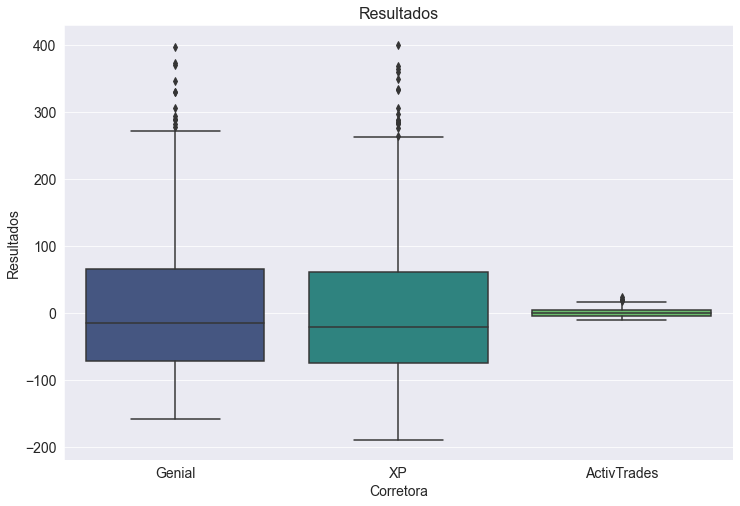

In [24]:
plt.figure(figsize=(12, 8))

sns.boxplot(data=df, x='corretora', y='resultado', palette='viridis')
plt.title('Resultados', fontsize=16)
plt.ylabel('Resultados', fontsize=14)
plt.xlabel('Corretora', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)

plt.show()

Temos assimetria positiva nos dados pois a mediana está mais próxima do Q1. Pouca variabilidade, porém, grande dispersão (valor máximo - valor mínimo). Os resultados, em grande parte, estão acima da mediana e também há vários outliers. Um nível menor de distribuição dos resultados na ActivTrades é devido a suas operações serem com lotes fracionados, resultando em lucros menores, porém, em dólar.

In [25]:
pd.DataFrame(df_xp['resultado'].describe())

,resultado
count,739.00
mean,0.56
std,98.97
min,-190.00
25%,-75.00
50%,-21.00
75%,60.50
max,401.00


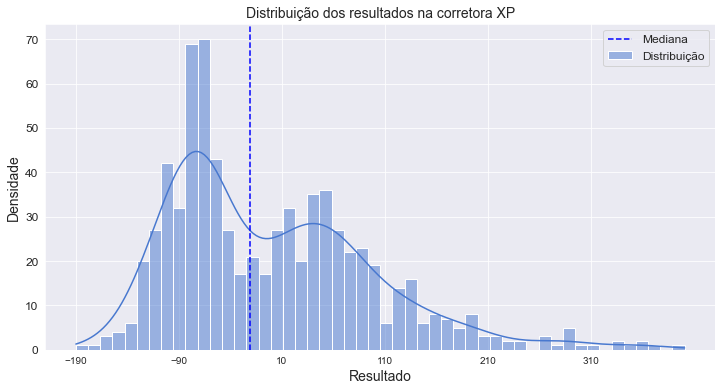

In [27]:
m_lucro_xp = df_xp['resultado'].median()

plt.figure(figsize=(12, 6))

sns.histplot(data=df_xp, x='resultado', label='Distribuição', kde=True, bins=50)
plt.axvline(m_lucro_xp, c='b', ls='--', label='Mediana')
plt.ticklabel_format(style='plain', axis='x')
plt.title('Distribuição dos resultados na corretora XP', fontsize=14)
plt.xlabel('Resultado', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.xticks(np.arange(df_xp['resultado'].min(), df_xp['resultado'].max(), step=100), size=10)

plt.show()

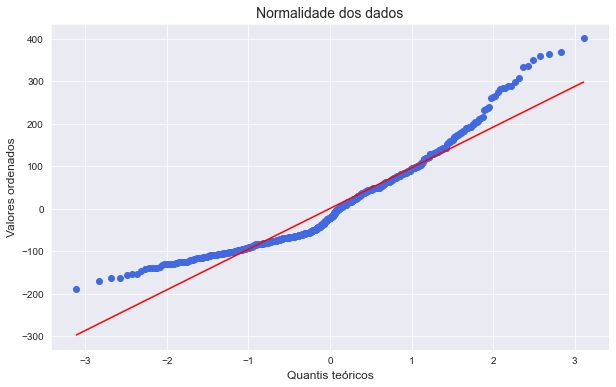

In [467]:
f, ax = plt.subplots(figsize=(10, 6))

stats.probplot(df_xp['resultado'], fit=True, plot=ax)
ax.set_title('Normalidade dos dados', fontsize=14)
ax.set_xlabel('Quantis teóricos', fontsize=12)
ax.set_ylabel('Valores ordenados', fontsize=12)

ax.get_lines()[0].set_color('#4169E1')
ax.get_lines()[0].set_markersize(6.0)

plt.show()

In [468]:
print('Teste de Shapiro Wilk\n---------------------------------')
print(f'Alpha: {0.05}')
print(f'p-value: {stats.shapiro(df_xp["resultado"])[1]:.20f}')
print('---------------------------------')

Teste de Shapiro Wilk
---------------------------------
Alpha: 0.05
p-value: 0.00000000000000000567
---------------------------------


Na corretora XP, comparando a média e o desvio padrão, vemos uma grande diferença, o que indica muitos resultados esparçados, outliers. A variância entre o valor mínimo e o valor máximo de lucro também é grande. Existe uma assimetria mais à esquerda e, besado no gráfico de QQ plot e também no teste de Shapiro Wilk, validamos que não há uma distribuição normal nos dados.

In [469]:
pd.DataFrame(df_genial['resultado'].describe())

,resultado
count,742.00
mean,4.28
std,97.71
min,-158.00
25%,-72.00
50%,-15.50
75%,66.00
max,398.00


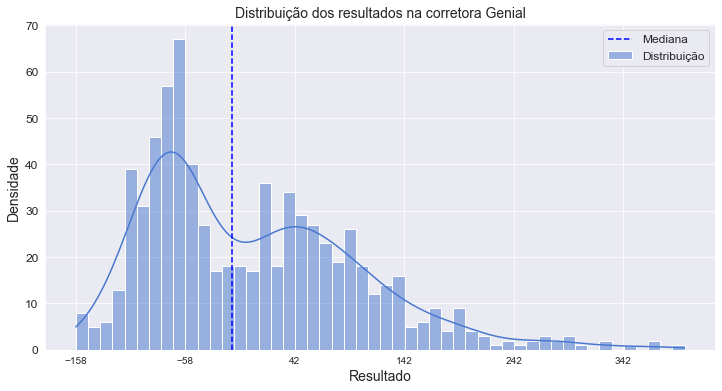

In [28]:
m_lucro_gn = df_genial['resultado'].median()

plt.figure(figsize=(12, 6))

sns.histplot(data=df_genial, x='resultado', label='Distribuição', kde=True, bins=50)
plt.axvline(m_lucro_gn, c='b', ls='--', label='Mediana')
plt.ticklabel_format(style='plain', axis='x')
plt.title('Distribuição dos resultados na corretora Genial', fontsize=14)
plt.xlabel('Resultado', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.xticks(np.arange(df_genial['resultado'].min(), df_genial['resultado'].max(), step=100), size=10)

plt.show()

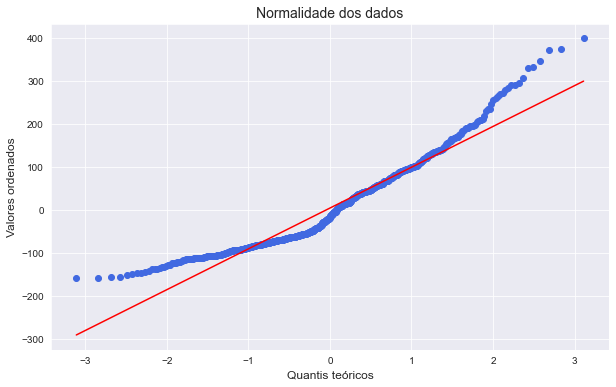

In [471]:
f, ax = plt.subplots(figsize=(10, 6))

stats.probplot(df_genial['resultado'], fit=True, plot=ax)
ax.set_title('Normalidade dos dados', fontsize=14)
ax.set_xlabel('Quantis teóricos', fontsize=12)
ax.set_ylabel('Valores ordenados', fontsize=12)

ax.get_lines()[0].set_color('#4169E1')
ax.get_lines()[0].set_markersize(6.0)

plt.show()

In [472]:
print('Teste de Shapiro Wilk\n---------------------------------')
print(f'Alpha: {0.05}')
print(f'p-value: {stats.shapiro(df_genial["resultado"])[1]:.20f}')
print('---------------------------------')

Teste de Shapiro Wilk
---------------------------------
Alpha: 0.05
p-value: 0.00000000000000001436
---------------------------------


Na corretora Genial também temos uma diferença expressiva entre a média e o desvio padrão, indicando outliers, e grande variância entre o lucro mínimo e o lucro máximo. Aqui a mediana é negativa, havendo assimetria à esquerda. Tanto o gráfico de QQ plot quanto o teste de Shapiro Wilk comprovam que os dados não estão numa distribuição normal.

In [473]:
pd.DataFrame(df_activ['resultado'].describe())

,resultado
count,553.00
mean,0.34
std,5.77
min,-10.83
25%,-4.22
50%,-0.75
75%,4.29
max,24.19


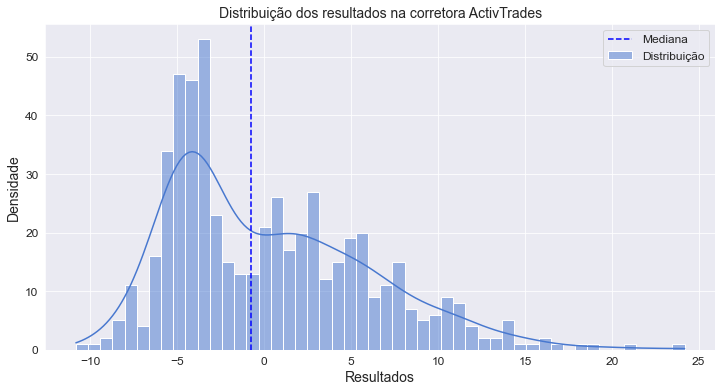

In [30]:
m_lucro_ac = df_activ['resultado'].median()

plt.figure(figsize=(12, 6))

sns.histplot(data=df_activ, x='resultado', label='Distribuição', kde=True, bins=50)
plt.axvline(m_lucro_ac, c='b', ls='--', label='Mediana')
plt.ticklabel_format(style='plain', axis='x')
plt.title('Distribuição dos resultados na corretora ActivTrades', fontsize=14)
plt.xlabel('Resultados', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
# plt.xticks(np.arange(df_activ['resultado'].min(), df_activ['resultado'].max(), step=100), size=10)

plt.show()

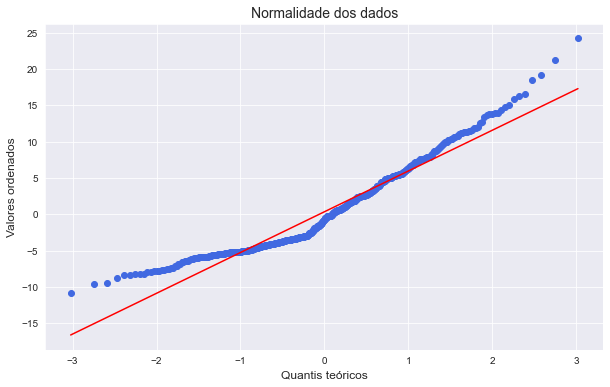

In [475]:
f, ax = plt.subplots(figsize=(10, 6))

stats.probplot(df_activ['resultado'], fit=True, plot=ax)
ax.set_title('Normalidade dos dados', fontsize=14)
ax.set_xlabel('Quantis teóricos', fontsize=12)
ax.set_ylabel('Valores ordenados', fontsize=12)

ax.get_lines()[0].set_color('#4169E1')
ax.get_lines()[0].set_markersize(6.0)

plt.show()

In [476]:
print('Teste de Shapiro Wilk\n---------------------------------')
print(f'Alpha: {0.05}')
print(f'p-value: {stats.shapiro(df_activ["resultado"])[1]:.20f}')
print('---------------------------------')

Teste de Shapiro Wilk
---------------------------------
Alpha: 0.05
p-value: 0.00000000000002033737
---------------------------------


Na corretora ActivTrades, caso parecido com XP e Genial. Existe uma diferença grande entre a média e o desvio padrão, indicando outliers. Mais um vez, grande variância entre lucro mínimo e lucro máximo. O gráfico de QQ plot e o teste de Shapiro Wilk comprovam que os dados não estão normalizados. Nota-se, também, que grande parte do lucro é negativa. 

### Resultados X lotes por corretora

In [477]:
lotes = df.groupby('corretora')['lotes_total'].count()
resultados = df.groupby('corretora')['resultado'].sum()

In [478]:
pd.DataFrame(lotes)

,lotes_total
corretora,
ActivTrades,553
Genial,742
XP,739


In [479]:
pd.DataFrame(resultados)

,resultado
corretora,
ActivTrades,188.96
Genial,3175.00
XP,417.00


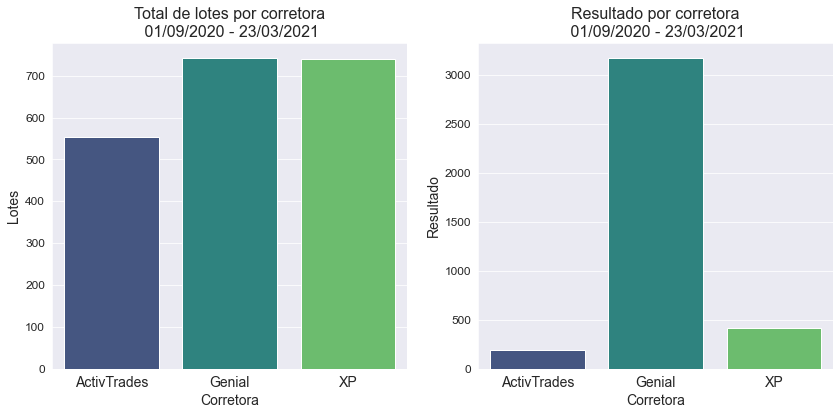

In [480]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
sns.barplot(x=lotes.index, y=lotes, palette='viridis') 
plt.title('Total de lotes por corretora\n 01/09/2020 - 23/03/2021', fontsize=16)
plt.xticks(size=14)
plt.ylabel('Lotes', fontsize=14)
plt.yticks(size=12)
plt.xlabel('Corretora', fontsize=14)

plt.subplot(122)
sns.barplot(x=resultados.index, y=resultados, palette='viridis')
plt.title('Resultado por corretora\n 01/09/2020 - 23/03/2021', fontsize=16)
plt.xticks(size=14)
plt.ylabel('Resultado', fontsize=14)
plt.yticks(size=12)
plt.xlabel('Corretora', fontsize=14)


plt.show()

No primeiro gráfico (esquerda) vemos o total de lotes negociados por corretora. A quantidade de lotes operados é maior nas corretoras que operam na B3 em relação a ActivTrades. Importante considerar que na ActivTrades os lotes são fracionados.

No segundo (direita) vemos os resultados obtidos por corretora. O maior foi na corretora Genial. Na ActivTrades, como dito, os lotes são fracionados e, portanto, é esperado um resultado menor.

XP e Genial operaram, praticamente, a mesma quantidade de lotes, porém, o resultado na corretora Genial é maior. É de conhecimento que em meados de Agosto/2020 ocorreram falhas na corretora XP que impactaram negativamente os resultados. 

###  Resultado Acumulado

In [481]:
df_xp = df_xp.sort_values(by='data', ascending=True)

In [482]:
df_xp['resultado_acum'] = df_xp['resultado'].cumsum()

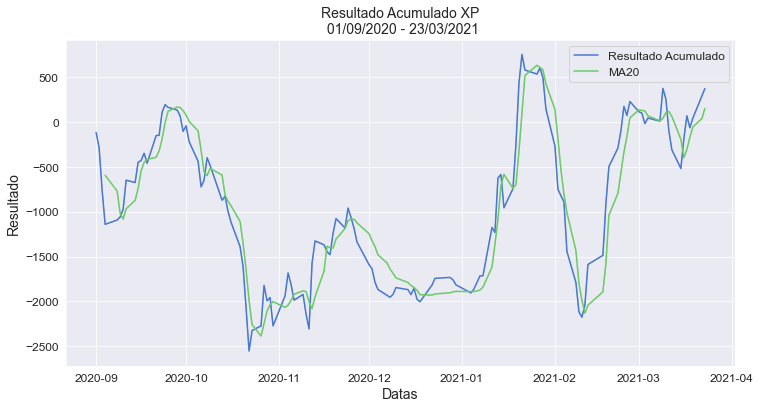

In [483]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=df_xp['data'], y=df_xp['resultado_acum'], ci=0, label='Resultado Acumulado')
sns.lineplot(x=df_xp['data'], y=df_xp['resultado_acum'].rolling(window=20).mean(), ci=0, label='MA20')
plt.xticks(fontsize=12)
plt.xlabel('Datas', fontsize=14)
plt.ylabel('Resultado', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Resultado Acumulado XP\n 01/09/2020 - 23/03/2021', fontsize=14)

plt.legend(fontsize=12)
plt.show()

O resultados acumulado da corretora XP, após uma leve recuperação de perdas em Setembeo/2020, teve uma grande queda em Outubro/2020, tendo uma pequena recuperação em Novembro e Dezembro/2020, corrigindo e recuperando as perdas em Janeiro/2021. Porém, uma forte queda iniciada no final de Janeiro/2021 devolve praticamente tudo e se inicia Fevereiro/2021 em queda, havendo nova recuperação. Em Março/2021 apresenta uma consolidação no resultado acumulado.

In [484]:
df_genial = df_genial.sort_values(by='data', ascending=True)

In [485]:
df_genial['resultado_acum'] = df_genial['resultado'].cumsum()

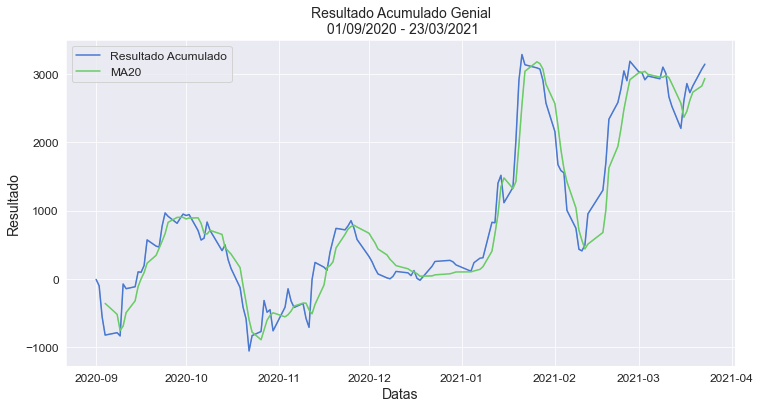

In [486]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=df_genial['data'], y=df_genial['resultado_acum'], ci=0, label='Resultado Acumulado')
sns.lineplot(x=df_genial['data'], y=df_genial['resultado_acum'].rolling(window=20).mean(), ci=0, label='MA20')
plt.xticks(fontsize=12)
plt.xlabel('Datas', fontsize=14)
plt.ylabel('Resultado', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Resultado Acumulado Genial\n 01/09/2020 - 23/03/2021', fontsize=14)

plt.legend(fontsize=12)
plt.show()

Já na corretora Genial, no mesmo período, o resultado acumulado se recupera bem em Setembro/2020, se aproximando dos R$1000, porém, também houve uma forte queda em Outubro/2020. Novembro e Dezembro/2020 apresentam uma recuperação, corrigindo um pouco e recuperando toda a perda em Janeiro/2021. Assim como na XP, uma forte queda iniciada no final de Janeiro/2021 devolve praticamente tudo e se inicia Fevereiro/2021 em queda, havendo nova recuperação. Em Março/2021 apresenta uma consolidação no resultado acumulado.

In [487]:
df_activ = df_activ.sort_values(by='data', ascending=True)

In [488]:
df_activ['resultado_acum'] = df_activ['resultado'].cumsum()

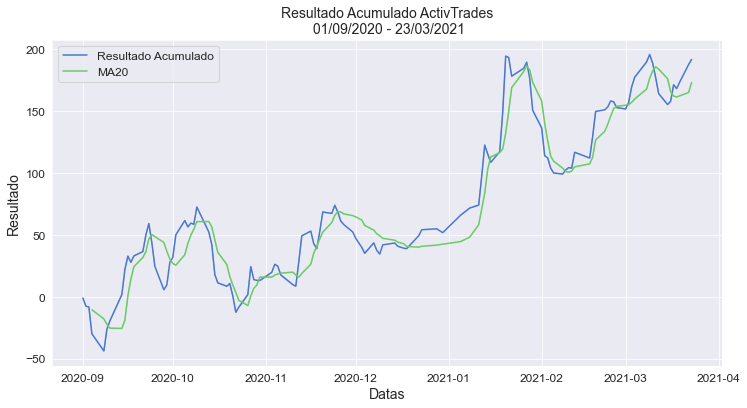

In [489]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=df_activ['data'], y=df_activ['resultado_acum'], ci=0, label='Resultado Acumulado')
sns.lineplot(x=df_activ['data'], y=df_activ['resultado_acum'].rolling(window=20).mean(), ci=0, label='MA20')
plt.xticks(fontsize=12)
plt.xlabel('Datas', fontsize=14)
plt.ylabel('Resultado', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Resultado Acumulado ActivTrades\n 01/09/2020 - 23/03/2021', fontsize=14)

plt.legend(fontsize=12)
plt.show()

Na corretora ActivTrades o resultado acumulado apresenta semelhanças com as corretoras B3, havendo forte queda em Outubro/2020, uma recuperação com correção mais acentuada entre Novembro e Dezembro/2020, levando até o final de Janeiro/2021 em alta. Inicia-se uma queda seguida de recuperação em Fevereiro/2021, entrando em Março/2021 com resultados em consolidação.

### Trades por dia e mês

In [490]:
pd.DataFrame(df_xp.groupby('dia')['resultado'].count())

,resultado
dia,
Qua,146
Qui,158
Seg,126
Sex,150
Ter,159


In [491]:
pd.DataFrame(df_genial.groupby('dia')['resultado'].count())

,resultado
dia,
Qua,148
Qui,158
Seg,126
Sex,150
Ter,160


In [492]:
pd.DataFrame(df_activ.groupby('dia')['resultado'].count())

,resultado
dia,
Qua,101
Qui,124
Seg,93
Sex,115
Ter,120


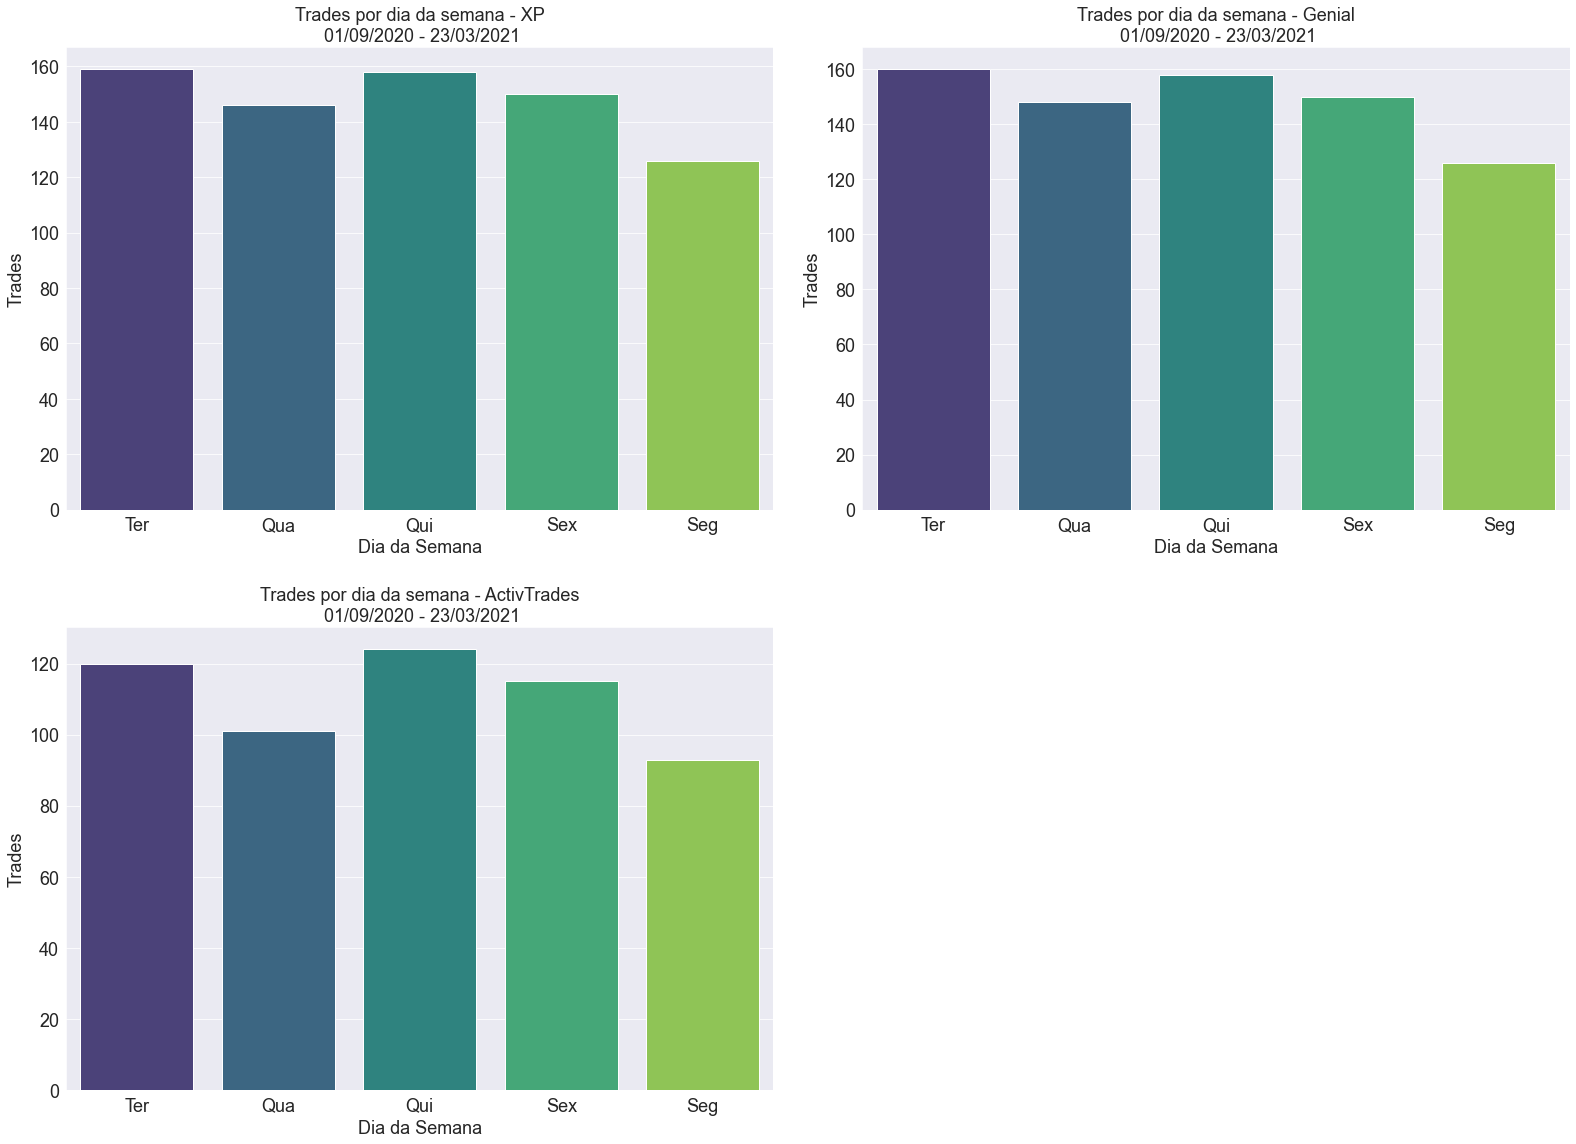

In [493]:
plt.figure(figsize=(22, 16))

plt.subplot(221)
sns.countplot(data=df_xp, x='dia', palette='viridis')
plt.xlabel('Dia da Semana', fontsize=18)
plt.ylabel('Trades', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Trades por dia da semana - XP\n 01/09/2020 - 23/03/2021', fontsize=18)
           
plt.subplot(222)
sns.countplot(data=df_genial, x='dia', palette='viridis')
plt.xlabel('Dia da Semana', fontsize=18)
plt.ylabel('Trades', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Trades por dia da semana - Genial\n 01/09/2020 - 23/03/2021', fontsize=18)

plt.subplot(223)
sns.countplot(data=df_activ, x='dia', palette='viridis')
plt.xlabel('Dia da Semana', fontsize=18)
plt.ylabel('Trades', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Trades por dia da semana - ActivTrades\n 01/09/2020 - 23/03/2021', fontsize=18)

plt.tight_layout(h_pad=3, w_pad=3)
plt.show()

A quantidade de trades executados por dia da semana nas corretoras XP e Genial são bem semelhantes, variando pouca coisa, quase imperceptível, variando em torno de 120 trades as segundas e 160 trades as terças e quintas. Na corretora ActivTrades, um pouco menos, variando em torno de 93 trades as segundas e 120 trades as terças e quintas.

Nota-se que em ambas as corretoras, terças e quintas são os dias em que mais se teve operações, seguidos de sextas e quartas. O dia em que se ocorre menos operações são as segundas.

In [494]:
pd.DataFrame(df_xp.groupby('mes')['resultado'].count())

,resultado
mes,
01/2021,121
02/2021,123
03/2021,89
09/2020,121
10/2020,143
11/2020,104
12/2020,38


In [495]:
pd.DataFrame(df_genial.groupby('mes')['resultado'].count())

,resultado
mes,
01/2021,122
02/2021,122
03/2021,89
09/2020,122
10/2020,144
11/2020,105
12/2020,38


In [496]:
pd.DataFrame(df_activ.groupby('mes')['resultado'].count())

,resultado
mes,
01/2021,86
02/2021,96
03/2021,62
09/2020,90
10/2020,111
11/2020,83
12/2020,25


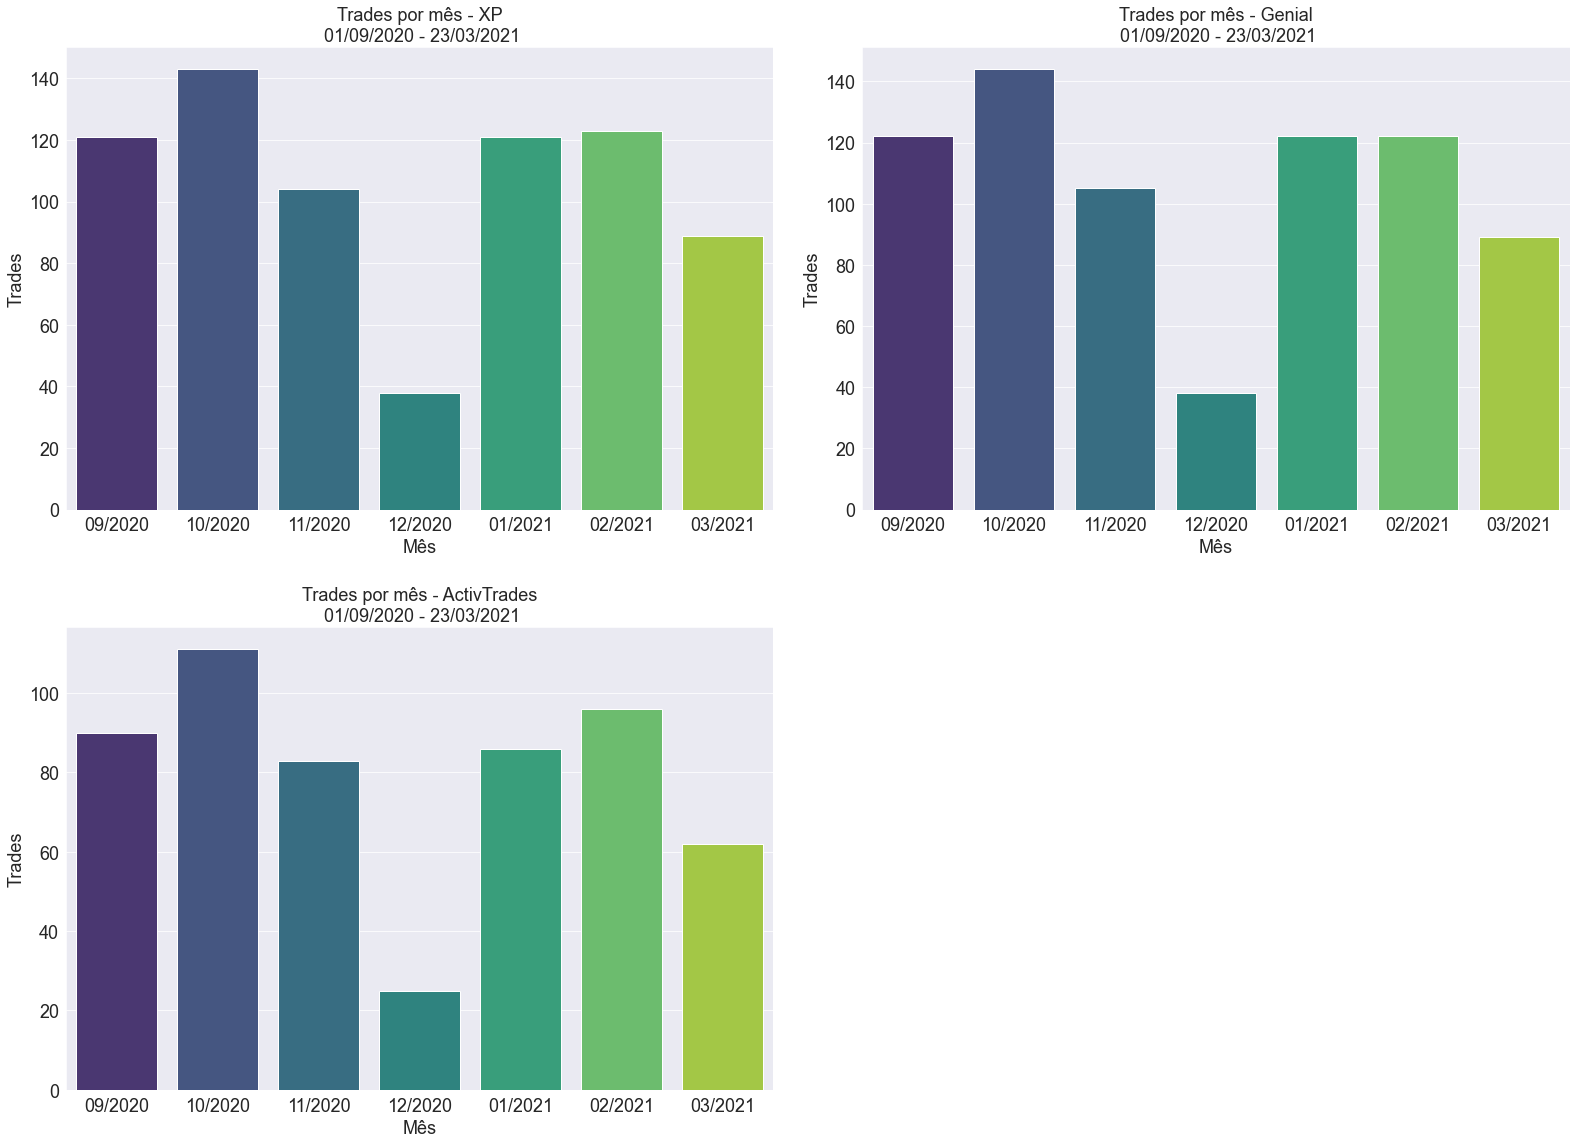

In [497]:
plt.figure(figsize=(22, 16))

plt.subplot(221)
sns.countplot(data=df_xp, x='mes', palette='viridis')
plt.xlabel('Mês', fontsize=18)
plt.ylabel('Trades', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Trades por mês - XP\n 01/09/2020 - 23/03/2021', fontsize=18)
           
plt.subplot(222)
sns.countplot(data=df_genial, x='mes', palette='viridis')
plt.xlabel('Mês', fontsize=18)
plt.ylabel('Trades', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Trades por mês - Genial\n 01/09/2020 - 23/03/2021', fontsize=18)

plt.subplot(223)
sns.countplot(data=df_activ, x='mes', palette='viridis')
plt.xlabel('Mês', fontsize=18)
plt.ylabel('Trades', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Trades por mês - ActivTrades\n 01/09/2020 - 23/03/2021', fontsize=18)

plt.tight_layout(h_pad=3, w_pad=3)
plt.show()

Nos meses analisados, em ambas as corretoras, outubro/2020 foi o mês com o maior número de operações, ultrapassando 140 trades nas corretoras B3 e mais de 100 na ActivTrades. Em 2020 setembro também teve por volta de 120 operações nas corretoras B3 e 90 na ActivTrades. Fevereiro e Janeiro de 2021 também foram meses com muitos trades em ambas as corretoras. Novembro e dezembro de 2020 foram os meses que menos tiveram operações, com dezembro não chegando a 40 trades em nenhuma corretora.

### Setups

In [498]:
sets_top5_xp = df_xp.groupby('nome_set')['resultado'].sum().sort_values(ascending=False).head()
sets_top5_gn = df_genial.groupby('nome_set')['resultado'].sum().sort_values(ascending=False).head()
sets_top5_ac = df_activ.groupby('nome_set')['resultado'].sum().sort_values(ascending=False).head()

sets_top5_r_xp = df_xp.groupby('nome_set')['resultado'].sum().sort_values().head()
sets_top5_r_gn = df_genial.groupby('nome_set')['resultado'].sum().sort_values().head()
sets_top5_r_ac = df_activ.groupby('nome_set')['resultado'].sum().sort_values().head()

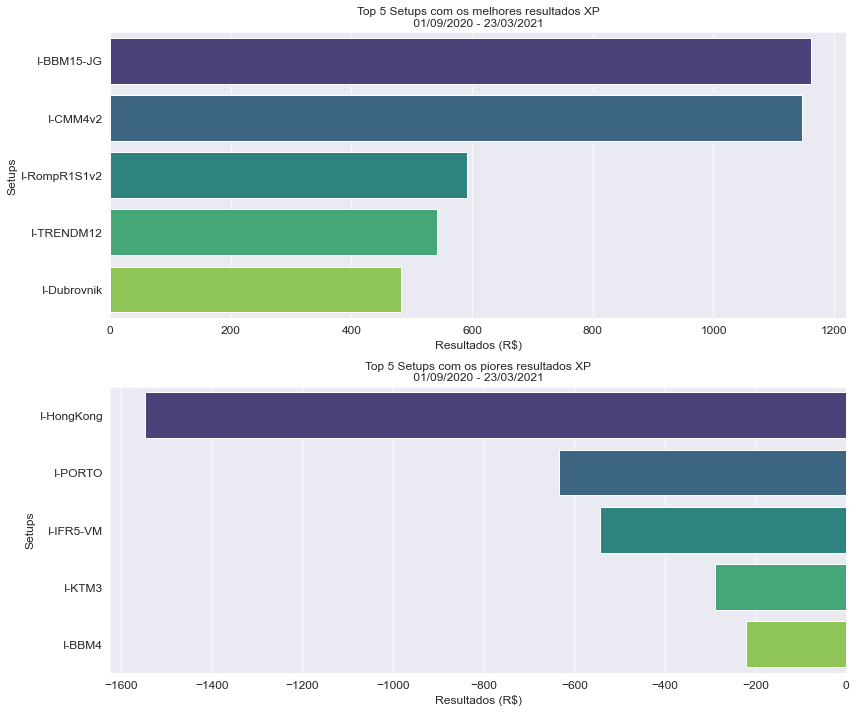

In [499]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
sns.barplot(y=sets_top5_xp.index, x=sets_top5_xp, palette='viridis')
plt.title('Top 5 Setups com os melhores resultados XP\n 01/09/2020 - 23/03/2021 ', fontsize=12)
plt.xticks(size=12)
plt.ylabel('Setups', fontsize=12)
plt.yticks(size=12)
plt.xlabel('Resultados (R$)', fontsize=12)

plt.subplot(212)
sns.barplot(y=sets_top5_r_xp.index, x=sets_top5_r_xp, palette='viridis', )
plt.title('Top 5 Setups com os piores resultados XP\n 01/09/2020 - 23/03/2021 ', fontsize=12)
plt.xticks(size=12)
plt.ylabel('Setups', fontsize=12)
plt.yticks(size=12)
plt.xlabel('Resultados (R$)', fontsize=12)

plt.tight_layout()
plt.show()

Analisando os 5 setups que melhor performaram na XP, BBM15-JG e CMM4v2 são os que mais obtiveram resultados positivos. Dubrovnik é um setup novo, com menos de 3 meses de operações, mas se nota que ele aparece à frente de setups mais antigos do portfólio.

Já os piores, HongKong aparece como o que possui os piores resultados, com uma diferença considerável para os demais que compõe esse ranking.

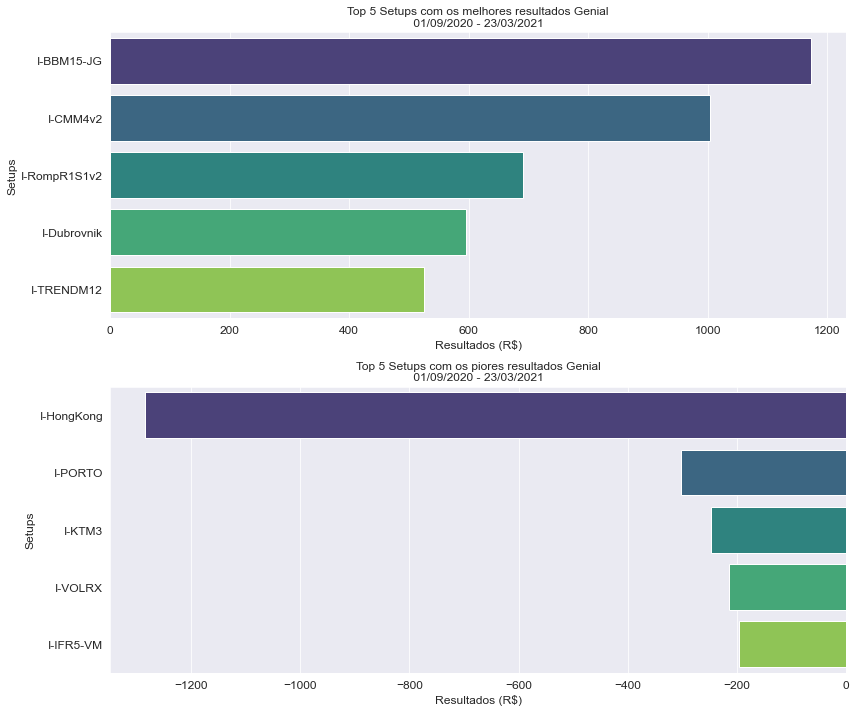

In [500]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
sns.barplot(y=sets_top5_gn.index, x=sets_top5_gn, palette='viridis')
plt.title('Top 5 Setups com os melhores resultados Genial\n 01/09/2020 - 23/03/2021 ', fontsize=12)
plt.xticks(size=12)
plt.ylabel('Setups', fontsize=12)
plt.yticks(size=12)
plt.xlabel('Resultados (R$)', fontsize=12)

plt.subplot(212)
sns.barplot(y=sets_top5_r_gn.index, x=sets_top5_r_gn, palette='viridis', )
plt.title('Top 5 Setups com os piores resultados Genial\n 01/09/2020 - 23/03/2021 ', fontsize=12)
plt.xticks(size=12)
plt.ylabel('Setups', fontsize=12)
plt.yticks(size=12)
plt.xlabel('Resultados (R$)', fontsize=12)

plt.tight_layout()
plt.show()

Na Genial, uma situação bem semelhante a XP, tendo o BBM15-JG como o que possui os melhores resultados, com uma diferença no setup CMM4v2 que obteve um menor resultado nesta corretora. Aqui o setup Dubrovnik teve um desepenho um pouco melhor que na XP, mesmo sendo um setup novo. Também como na XP, HongKong é o setup com os piores resultados, com grande diferença para os demais que compõe o ranking negativo.

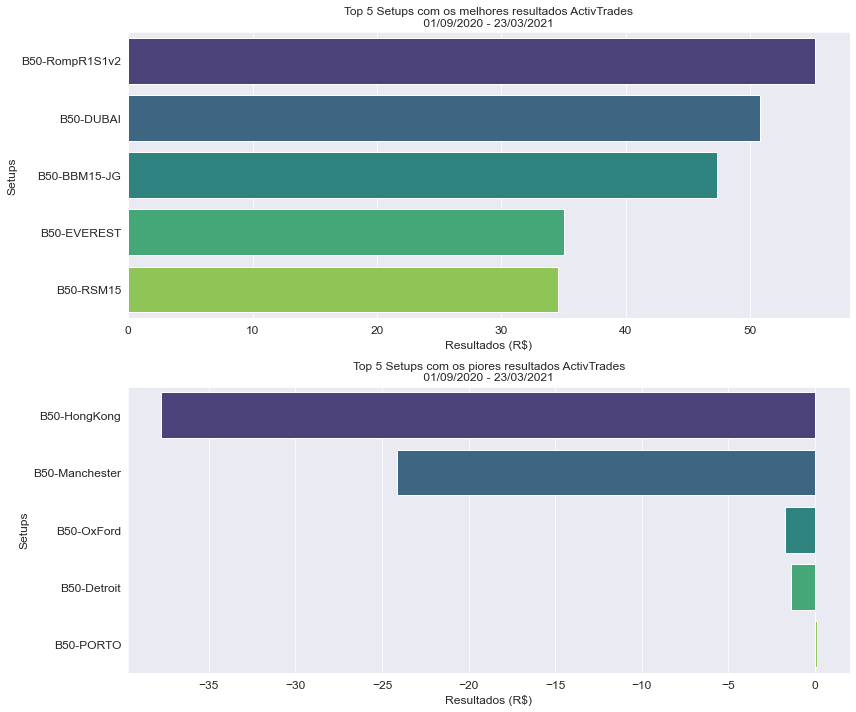

In [501]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
sns.barplot(y=sets_top5_ac.index, x=sets_top5_ac, palette='viridis')
plt.title('Top 5 Setups com os melhores resultados ActivTrades\n 01/09/2020 - 23/03/2021 ', fontsize=12)
plt.xticks(size=12)
plt.ylabel('Setups', fontsize=12)
plt.yticks(size=12)
plt.xlabel('Resultados (R$)', fontsize=12)

plt.subplot(212)
sns.barplot(y=sets_top5_r_ac.index, x=sets_top5_r_ac, palette='viridis', )
plt.title('Top 5 Setups com os piores resultados ActivTrades\n 01/09/2020 - 23/03/2021 ', fontsize=12)
plt.xticks(size=12)
plt.ylabel('Setups', fontsize=12)
plt.yticks(size=12)
plt.xlabel('Resultados (R$)', fontsize=12)

plt.tight_layout()
plt.show()

Na ActivTrades, o setup que obteve os melhores resultados foi o RompR1S1v2, seguido por DUBAI e BBM15-JG. Também na ActivTrades, o setup HongKong obteve os piores resultados, com grande diferença para os demais. Deve-se levar em consideração alguns fatores, como o tamanho do lote, que na ActivTrades é fracionado e o ativo, mesmo sendo um CFD do mini índice, se difere um pouco. Os setups, em comparação aos que rodam na B3, possuem algumas semelhanças, mas não são iguais.

### Tipo de Operação

In [502]:
tipo_xp = df_xp.groupby('tipo_trade')['resultado'].count()
tipo_gn = df_genial.groupby('tipo_trade')['resultado'].count()
tipo_ac = df_activ.groupby('tipo_trade')['resultado'].count()

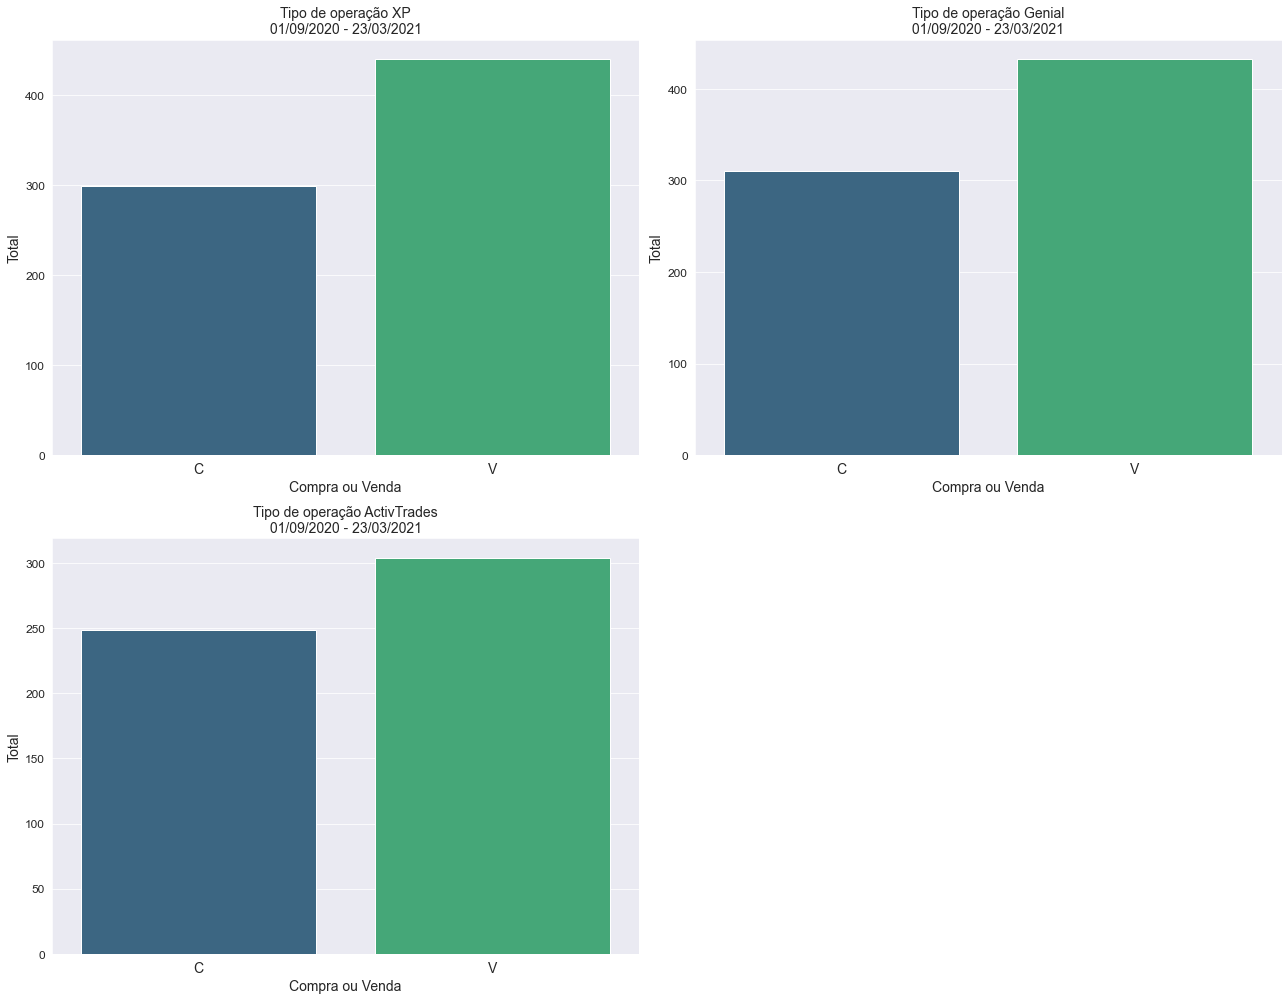

In [503]:
plt.figure(figsize=(18, 14))

plt.subplot(221)
sns.barplot(x=tipo_xp.index, y=tipo_xp, palette='viridis')
plt.title('Tipo de operação XP\n 01/09/2020 - 23/03/2021 ', fontsize=14)
plt.xticks(size=14)
plt.ylabel('Total', fontsize=14)
plt.yticks(size=12)
plt.xlabel('Compra ou Venda', fontsize=14)

plt.subplot(222)
sns.barplot(x=tipo_gn.index, y=tipo_gn, palette='viridis')
plt.title('Tipo de operação Genial\n 01/09/2020 - 23/03/2021 ', fontsize=14)
plt.xticks(size=14)
plt.ylabel('Total', fontsize=14)
plt.yticks(size=12)
plt.xlabel('Compra ou Venda', fontsize=14)

plt.subplot(223)
sns.barplot(x=tipo_ac.index, y=tipo_ac, palette='viridis')
plt.title('Tipo de operação ActivTrades\n 01/09/2020 - 23/03/2021 ', fontsize=14)
plt.xticks(size=14)
plt.ylabel('Total', fontsize=14)
plt.yticks(size=12)
plt.xlabel('Compra ou Venda', fontsize=14)

plt.tight_layout()
plt.show()

Claramente, operações de venda são as mais executadas.